## Rebuild the parametrized circuit in AWS Braket

In [1]:
import numpy as np

from qiskit import QuantumCircuit, QuantumRegister
from qiskit.circuit import ParameterVector
from qiskit.primitives import BackendEstimator, Estimator, Sampler, BackendSampler

from braket.devices import LocalSimulator
from braket.circuits import Circuit, Gate, Instruction, QubitSet, AngledGate, Observable
from braket.circuits import noises
from braket.circuits.gates import X, Y, Z, Rx, Rz, CNot, XY, PulseGate, U, XX, ZZ
from braket.quantum_information import PauliString, ExtendedPauliString
from braket.parametric import FreeParameter, FreeParameterExpression
from braket.circuits.observables import TensorProduct

from qiskit_braket_provider.providers import adapter
from qiskit_braket_provider import AWSBraketProvider


In [2]:
action_vector = np.pi * np.array([0.0, 0.0, 0.5, 0.5, -0.5, 0.5, -0.5]) # np.random.uniform(-np.pi, np.pi, 7)

Qiskit implementation of ``parametrized_circuit``

/Users/lukasvoss/anaconda3/envs/braket/lib/python3.10/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


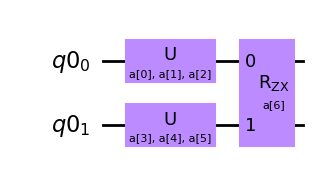

In [3]:
q_reg = QuantumRegister(2)
baseline = np.pi * np.zeros(len(action_vector))
params = ParameterVector("a", 7)
qiskit_circuit = QuantumCircuit(q_reg, name="custom_cx")
# optimal_params = np.pi * np.array([0.0, 0.0, 0.5, 0.5, -0.5, 0.5, -0.5])
optimal_params = np.pi * np.zeros(7)

qiskit_circuit.u(
    baseline[0] + params[0],
    baseline[1] + params[1],
    baseline[2] + params[2],
    q_reg[0],
)
qiskit_circuit.u(
    baseline[3] + params[3],
    baseline[4] + params[4],
    baseline[5] + params[5],
    q_reg[1],
)

qiskit_circuit.rzx(baseline[6] + params[6], q_reg[0], q_reg[1])
qiskit_circuit.draw("mpl")

Conversion of Qiskit circuit to Braket circuit

In [4]:
braket_circuit_converted = adapter.convert_qiskit_to_braket_circuit(qiskit_circuit)

print(braket_circuit_converted)

T  : |      0      |1|2|  3   |4|5|
                                   
q0 : -U(a0, a1, a2)---C--------C---
                      |        |   
q1 : -U(a3, a4, a5)-H-X-Rz(a6)-X-H-

T  : |      0      |1|2|  3   |4|5|

Unassigned parameters: [a0, a1, a2, a3, a4, a5, a6].


#### Braket Version

In [5]:
braket_circuit = Circuit()

baseline = np.pi * np.zeros(len(action_vector))
params = [FreeParameter(f"a{i}") for i in range(0, len(action_vector))]

u1 = U(
    baseline[0] + params[0], 
    baseline[1] + params[1], 
    baseline[1] + params[2],
)
u2 = U(
    baseline[3] + params[3], 
    baseline[4] + params[4], 
    baseline[5] + params[5],
)

# rzx = RZX(
#     baseline[6] + params[6]
# )

braket_circuit.add_instruction(Instruction(u1, [0]))
braket_circuit.add_instruction(Instruction(u2, [1]))
print(braket_circuit)

T  : |      0      |
                    
q0 : -U(a0, a1, a2)-
                    
q1 : -U(a3, a4, a5)-

T  : |      0      |

Unassigned parameters: [a0, a1, a2, a3, a4, a5].


In [6]:
def rzx(theta, register):
    """
    RZX gate decomposition for angle theta
    """
    q1, q2 = register
    qc = Circuit()

    # Step 1: Apply Hadamard gate to the target qubit
    qc.h(q2)

    # Step 2: Apply CNOT gate with q1 as control and q2 as target
    qc.cnot(q1, q2)

    # Step 3: Apply RZ gate with angle theta to the target qubit
    # Since Braket's RZ gate uses full angle, there's no need to divide theta by 2
    qc.rz(q2, angle=theta)

    # Step 4: Apply another CNOT gate with q1 as control and q2 as target
    qc.cnot(q1, q2)

    # Step 5: Apply Hadamard gate to the target qubit again
    qc.h(q2)
    
    return qc

Circuit.register_subroutine(rzx)

braket_circuit.rzx(baseline[6] + params[6], [0, 1])

print(braket_circuit)

T  : |      0      |1|2|  3   |4|5|
                                   
q0 : -U(a0, a1, a2)---C--------C---
                      |        |   
q1 : -U(a3, a4, a5)-H-X-Rz(a6)-X-H-

T  : |      0      |1|2|  3   |4|5|

Unassigned parameters: [a0, a1, a2, a3, a4, a5, a6].


Sanity Checks if RZX was correclty implemented

In [7]:
sigma_x = np.array([[0, 1], [1, 0]])
sigma_z = np.array([[1, 0], [0, -1]])

new_circ = Circuit()
check1 = np.isclose(new_circ.rzx(0, [0, 1]).to_unitary(), np.eye(4), atol=1e-8)
new_circ = Circuit()
check2 = np.isclose(new_circ.rzx(2*np.pi, [0, 1]).to_unitary(), -np.eye(4), atol=1e-8)
new_circ = Circuit()
check3 = np.isclose(new_circ.rzx(np.pi, [0, 1]).to_unitary(), -1j * np.kron(sigma_z, sigma_x), atol=1e-8)

if check1.all() and check2.all() and check3.all():
    print("RZX gate is implemented correctly!")

RZX gate is implemented correctly!


In [8]:
device = LocalSimulator() # Noise-Free statevector simulation
n_shots = 1000

# device = LocalSimulator(backend="braket_dm") # For simulations with noise

In [9]:
param_names = [str(param) for param in params]
bound_parameters = dict(zip(param_names, action_vector))

print('Braket Circuit: \n\n', braket_circuit)
print('\n\nQiskit to Braket Circuit Conversion: \n\n', braket_circuit_converted)
print('\n\nConverted circuit and native Braket circuit are equivalent:', braket_circuit == braket_circuit_converted)
if braket_circuit != braket_circuit_converted:
    raise ValueError('Circuit conversion failed')

Braket Circuit: 

 T  : |      0      |1|2|  3   |4|5|
                                   
q0 : -U(a0, a1, a2)---C--------C---
                      |        |   
q1 : -U(a3, a4, a5)-H-X-Rz(a6)-X-H-

T  : |      0      |1|2|  3   |4|5|

Unassigned parameters: [a0, a1, a2, a3, a4, a5, a6].


Qiskit to Braket Circuit Conversion: 

 T  : |      0      |1|2|  3   |4|5|
                                   
q0 : -U(a0, a1, a2)---C--------C---
                      |        |   
q1 : -U(a3, a4, a5)-H-X-Rz(a6)-X-H-

T  : |      0      |1|2|  3   |4|5|

Unassigned parameters: [a0, a1, a2, a3, a4, a5, a6].


Converted circuit and native Braket circuit are equivalent: True


In [10]:
# run the circuit on the local simulator
task = device.run(braket_circuit, shots=n_shots, inputs=bound_parameters)

# visualize the results
result = task.result()
measurement = result.measurement_counts
print('measurement results:', measurement)

measurement results: Counter({'00': 1000})


### Measuring expectation values

In [11]:
from braket.circuits.observables import Sum

In [12]:
# TODO: Create a weighted sum of pauli observables

observable_string_xx = "XX"
observable_string_zz = "ZZ"

In [13]:
PauliString(observable_string_xx).to_unsigned_observable() + PauliString(observable_string_zz).to_unsigned_observable()

Sum(TensorProduct(X('qubit_count': 1), X('qubit_count': 1)), TensorProduct(Z('qubit_count': 1), Z('qubit_count': 1)))

In [14]:
pauli_operator = Sum(observables=[0.5 * PauliString(observable_string_xx).to_unsigned_observable(), 0.5 * PauliString(observable_string_zz).to_unsigned_observable()], display_name='0.5XX + 0.5ZZ')

In [15]:
pauli_operator.ascii_symbols

('0.5XX + 0.5ZZ', '0.5XX + 0.5ZZ')

In [16]:
list(pauli_operator.summands)[0].coefficient

0.5

#### Measure expectation values on the native braket circuit

In [17]:
# paulis = ExtendedPauliString(pauli_strings=['XX', 'ZZ'], coefficients=[0.5, 0.5])
# paulis.to_tensor_product()

In [18]:
temp = 0.5*Observable.X()
temp.ascii_symbols

('0.5X',)

In [19]:
t1 = 0.5 * Observable.X()
print(t1.ascii_symbols)
t1.to_matrix()


t2 = 0.5 * Observable.Z()
print(t2.ascii_symbols)
t2.to_matrix()

('0.5X',)
('0.5Z',)


array([[ 0.5+0.j,  0. +0.j],
       [ 0. +0.j, -0.5+0.j]])

In [20]:
observable = TensorProduct([t1, t2])

In [21]:
TensorProduct([t1, t2]).to_matrix()

array([[ 0.  +0.j,  0.  +0.j,  0.25+0.j,  0.  +0.j],
       [ 0.  +0.j, -0.  +0.j,  0.  +0.j, -0.25+0.j],
       [ 0.25+0.j,  0.  +0.j,  0.  +0.j,  0.  +0.j],
       [ 0.  +0.j, -0.25+0.j,  0.  +0.j, -0.  +0.j]])

In [22]:
op = TensorProduct([Observable.X(), Observable.Z()])
# op = TensorProduct([Observable.X(), Observable.Z()])
op.ascii_symbols

('X@Z', 'X@Z')

In [23]:
# Create a small circuit with a free parameter theta
pauli_string = PauliString(observable_string_xx)
pauli_operator = pauli_string.to_unsigned_observable()

# braket_circuit.state_vector() # Get the state vector of the circuit # Can only be determined for shots=0
braket_circuit.expectation(observable=observable, target=[0, 1]) # Get the expectation value of the Pauli operator

# pauli_string = PauliString(observable_string_xx)
# pauli_operator = 0.5*pauli_string.to_unsigned_observable()
# braket_circuit.expectation(observable=pauli_operator, target=[0, 1]) 
print(braket_circuit)

# Small value for test purposes
# batchsize = 5
# batch_circuits = [circ] * batchsize

T  : |      0      |1|2|  3   |4|5|    Result Types    |
                                                        
q0 : -U(a0, a1, a2)---C--------C---Expectation(0.25X@Z)-
                      |        |   |                    
q1 : -U(a3, a4, a5)-H-X-Rz(a6)-X-H-Expectation(0.25X@Z)-

T  : |      0      |1|2|  3   |4|5|    Result Types    |

Unassigned parameters: [a0, a1, a2, a3, a4, a5, a6].


In [24]:
bound_parameters

{'a0': 0.0,
 'a1': 0.0,
 'a2': 1.5707963267948966,
 'a3': 1.5707963267948966,
 'a4': -1.5707963267948966,
 'a5': 1.5707963267948966,
 'a6': -1.5707963267948966}

In [25]:
job = device.run(braket_circuit, shots=n_shots, inputs=bound_parameters)

# Run multiple circuits at once
# job = device.run_batch(
#     batch_circuits,
#     inputs={'theta': thetas}, 
#     shots=100
# )

print('Measurement Counts:', job.result().measurement_counts)
print('Measurement Probabilities:', job.result().measurement_probabilities)

# print("Final EXACT state vector:\n", job.result().values[0])
print(f"Expectation value <XZ>:", np.round(job.result().values[0], 5))

line 1:26 mismatched input '0.25' expecting {'x', 'y', 'z', 'i', 'h', 'hermitian'}


TypeError: cannot unpack non-iterable NoneType object

In [ ]:
from braket.circuits import Circuit, Observable
from braket.devices import LocalSimulator

# Define your Hamiltonian
observable = 0.25 * Observable.X() @ Observable.X() + 0.5 * Observable.Z() @ Observable.Z()

# Initialize your quantum circuit as needed
circuit = Circuit()
circuit.x(0)
# circuit.h(0).cnot(0, 1)

Circuit('instructions': [Instruction('operator': X('qubit_count': 1), 'target': QubitSet([Qubit(0)]), 'control': QubitSet([]), 'control_state': (), 'power': 1)])

In [ ]:
# Define observables for each qubit
observable_q0 = Observable.X() + Observable.X()
observable_q1 = Observable.Z() + Observable.Z()

# Measure the expectation value for the observable on qubit 0
circuit.expectation(observable=observable_q0, target=[[0], [0]])

# Measure the expectation value for the observable on qubit 1
circuit.expectation(observable=observable_q1, target=[[1], [1]])
print(circuit)

# Add your quantum gates to prepare the state |psi>
# For example, circuit.h(0).cnot(0, 1) to prepare an entangled state


# Set the device to run your circuit
device = LocalSimulator()

# Run the circuit with the observable to measure the expectation value
task = device.run(circuit, shots=1000)

# Get the result
result = task.result()

# # Extract the expectation value from the result
expectation_values = result.values

print(f"\nExpectation value: {expectation_values}")

T  : |0|      Result Types      |
                                 
q0 : -X-Expectation(Hamiltonian)-
                                 
q1 : ---Expectation(Hamiltonian)-

T  : |0|      Result Types      |

Expectation value: [-0.01, 1.0]


#### Run a small batch of braket cirucits with ``run_batch``

In [ ]:
batchsize = 5

# Create a list of circuits
batch_circuits = [braket_circuit] * batchsize

# Create a list of parameter dicts
batch_bound_parameters = [bound_parameters] * batchsize

In [ ]:
batch_results = device.run_batch(batch_circuits, inputs=batch_bound_parameters, shots=n_shots)

In [ ]:
for ind, result in enumerate(batch_results.results()):
    print('Batch Number:', ind)
    print('Measurement Counts:', result.measurement_counts)
    print('Measurement Probabilities:', result.measurement_probabilities)
    print(f"Expectation value <XZ>:", np.round(result.values[0], 5), '\n')

Batch Number: 0
Measurement Counts: Counter({'10': 505, '00': 495})
Measurement Probabilities: {'00': 0.495, '10': 0.505}
Expectation value <XZ>: -0.01 

Batch Number: 1
Measurement Counts: Counter({'00': 509, '10': 491})
Measurement Probabilities: {'00': 0.509, '10': 0.491}
Expectation value <XZ>: 0.018 

Batch Number: 2
Measurement Counts: Counter({'00': 538, '10': 462})
Measurement Probabilities: {'00': 0.538, '10': 0.462}
Expectation value <XZ>: 0.076 

Batch Number: 3
Measurement Counts: Counter({'00': 512, '10': 488})
Measurement Probabilities: {'10': 0.488, '00': 0.512}
Expectation value <XZ>: 0.024 

Batch Number: 4
Measurement Counts: Counter({'00': 505, '10': 495})
Measurement Probabilities: {'10': 0.495, '00': 0.505}
Expectation value <XZ>: 0.01 



#### Run same circuit with Qiskit Statevector Estimator

In [ ]:
from qiskit.primitives import Estimator
from qiskit.quantum_info.operators import SparsePauliOp

estimator = Estimator()
observable = SparsePauliOp(
    [observable_string_xx], # , observable_string_zz], 
    coeffs=[1.0] #, 1.0]
)

In [ ]:
qiskit_circuit.draw('mpl')

In [ ]:
qiskit_job = estimator.run(
    circuits=qiskit_circuit, 
    observables=observable, 
    parameter_values=action_vector,
    shots=n_shots
)

In [ ]:
def create_expectation_string(prefactors, observable_strings):
    if len(prefactors) != len(observable_strings):
        raise ValueError("The lengths of prefactors and observable_strings should be the same.")

    expectation_string = "Expectation value "
    for i in range(len(prefactors)):
        expectation_string += f"{prefactors[i]}*<{observable_strings[i]}>"
        if i < len(prefactors) - 1:
            expectation_string += " + "

    expectation_string += ":"

    return expectation_string

In [ ]:
print(create_expectation_string(observable.coeffs, observable.settings['data']), qiskit_job.result().values)

In [ ]:
elif isinstance(backend, (BraketLocalBackend, AWSBraketBackend)):
    # Can be used for the SV1 simulator of AWS Braket
    if abstraction_level != "circuit":
        raise ValueError("Statevector simulation only works at circuit level")
    estimator = BackendEstimator(backend) # Create a BackendEstimator object from the braket-provider backend (which is a BackendV2 object)
    sampler = BackendSampler(backend) # options={"initial_layout": layout})


#### Create BackendEstimator out of Qiskit-Braket-Provider backend

In [ ]:
# backend = AWSBraketProvider().get_backend('SV1')
# qiskit_estimator_from_braket = BackendEstimator(backend)

# job = qiskit_estimator_from_braket.run(
#     circuits=qiskit_circuit, 
#     observables=observable, 
#     parameter_values=action_vector,
#     shots=n_shots
# )

In [ ]:
# job = qiskit_estimator_from_braket.run(
#     circuits=qiskit_circuit, 
#     observables=observable, 
#     parameter_values=action_vector,
#     shots=n_shots
# )

In [ ]:
# job.result().values

## BraketEstimator

In [41]:
import numpy as np
from braket.aws import AwsDevice
from braket.circuits import Circuit, Observable

class BraketEstimator:
    def __init__(self, backend):
        """
        Initialize the estimator with a specific AWS Braket backend.
        :param backend: An instance of AwsDevice
        """
        self.backend = backend

    def estimate(self, circuits, observables, targets, parameters=None):
        """
        Estimate the expectation values of the given observables for the provided circuits.
        :param circuits: List of Braket Circuit objects
        :param observables: List of Observables corresponding to each circuit
        :param targets: List of qubit indices for which the observable is to be measured corresponding to each circuit
        :param parameters: List of dictionaries mapping parameter names to values
        :return: List of estimated expectation values
        """
        expectation_values = []
        measurement_counts = []

        for idx, circuit in enumerate(circuits):
            if parameters:
                # Bind parameters here
                param_dict = parameters[idx]
                for name, value in param_dict.items():
                    circuit = circuit.bind_parameters({name: value})

            # Add measurement based on the observable
            # For simplicity, assuming single-qubit Pauli observables
            circuit.expectation(observable=observables[idx], target=targets[idx])

            # Run the circuit
            task = self.backend.run(circuit, shots=1000)
            result = task.result()

            # Compute expectation value from result
            # This is a simplified example; actual computation depends on the observable
            measurement_counts = result.measurement_counts
            measurement_counts.append(measurement_counts)
            expectation_value = result.values # self.compute_expectation_value(counts)
            expectation_values.append([expectation_value])

        return measurement_counts, expectation_values

    @staticmethod
    def compute_expectation_value(counts):
        """
        Compute the expectation value from measurement counts.
        This is a simplified example and might need to be adjusted based on the observable.
        """
        expectation_value = 0
        for outcome, count in counts.items():
            # Assuming 0 maps to +1 eigenvalue and 1 maps to -1
            sign = 1 if outcome == '0' else -1
            expectation_value += sign * count
        expectation_value /= sum(counts.values())
        return expectation_value

In [45]:
# Example usage
backend = AWSBraketProvider().get_backend('SV1')
estimator = BraketEstimator(backend)

In [56]:
# Define your circuits and observables here
circuits = [Circuit().h(0), Circuit().x(0)]
observables = [Observable.Z(), Observable.X()]
parameters = [None, None]  # Assuming no parameters for simplicity

# expectation_values = estimator.estimate(circuits, observables, targets=[0, 0], parameters=None)
# print(expectation_values)

In [60]:
circuits = [Circuit().h(0), Circuit().x(0)]
observables = [Observable.Z(), Observable.X()]
targets=[0, 0]
parameters=None

expectation_values = []
measurement_counts = []

for idx, circuit in enumerate(circuits):
    if parameters:
        # Bind parameters here
        param_dict = parameters[idx]
        for name, value in param_dict.items():
            circuit = circuit.bind_parameters({name: value})
    
    # # Add measurement based on the observable
    # # For simplicity, assuming single-qubit Pauli observables
    circuit.expectation(observable=observables[idx], target=targets[idx])
    print(idx, circuit)
    
    # # Run the circuit
    task = backend.run(circuit, shots=1000)
    result = task.result()

    # # Compute expectation value from result
    # # This is a simplified example; actual computation depends on the observable
    # measurement_counts = result.measurement_counts
    # measurement_counts.append(measurement_counts)
    # expectation_value = result.values # self.compute_expectation_value(counts)
    # expectation_values.append([expectation_value])

0 T  : |0| Result Types |
                       
q0 : -H-Expectation(Z)-

T  : |0| Result Types |


QiskitBraketException: Unsupported input type: <class 'braket.circuits.circuit.Circuit'>